# Comparing DBSCAN and HDBSCAN Clustering 


In [1]:
!pip install numpy==2.2.0
!pip install pandas==2.2.3
!pip install scikit-learn==1.6.0
!pip install matplotlib==3.9.3
!pip install hdbscan==0.8.40
!pip install geopandas==1.0.1
!pip install contextily==1.6.2
!pip install shapely==2.0.6

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.2 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 56.5 MB/s eta 0:00:00 0:00:010:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
astropy 5.3.4 requires numpy<2,>=1.21, but you have numpy 2.2.0 which is incompatible.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.2.0 which is incompatible.
numba 0.59.1 requires numpy<1.27,>=1.22, but you have numpy 2.2.0 which is incompatible.
pywavelets 1.5.0 requires numpy<2.0,>=1.22.4, but you have numpy 2.2.0 which is 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.preprocessing import StandardScaler

# geographical tools
import geopandas as gpd  # pandas dataframe-like geodataframes for geographical data
import contextily as ctx  # used for obtianing a basemap of Canada
from shapely.geometry import Point

import warnings
warnings.filterwarnings('ignore')

## Download the Canada map for reference


https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/YcUk-ytgrPkmvZAh5bf7zA/Canada.zip



In [5]:
import os
print(os.listdir('.'))


['.ipynb_checkpoints', 'ML_Pipelines_and_GridSearchCV.ipynb', 'DA0101EN-2-Review-Data-Wrangling.ipynb', 'Evaluating_random_forest.ipynb', 'Exploratory_data_analysis_cars.ipynb', 'K-Means-Customer-Seg.ipynb', 'Regularization_in_LinearRegression.ipynb', 'Evaluating Classification Models.ipynb', 'decision_tree_svm_ccFraud.ipynb', 'Multi-class_Classification.ipynb', 'DB0201EN-Week3-1-2-Querying.ipynb', 'Comparing_DBScan_HDBScan.ipynb', 'CreatingMap_Practice.ipynb', 'Random_ Forests _XGBoost.ipynb', 'creditcard.csv', 'PCA.ipynb', 'Evaluating_k-means_clustering.ipynb']


In [8]:
print(os.getcwd())

/home/af2ea8f5-1f9a-4091-9c13-db2b59ea1801/Skill Network/Machine Learning


In [10]:
import rasterio
tif_path = 'Canada.tif'

with rasterio.open(tif_path) as src:
    print("CRS:", src.crs)


CRS: EPSG:3857


## Include a plotting function


In [11]:
# Write a function that plots clustered locations and overlays them on a basemap.

def plot_clustered_locations(df,  title='Museums Clustered by Proximity'):
    """
    Plots clustered locations and overlays on a basemap.
    
    Parameters:
    - df: DataFrame containing 'Latitude', 'Longitude', and 'Cluster' columns
    - title: str, title of the plot
    """
    
    # Load the coordinates intto a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']), crs="EPSG:4326")
    
    # Reproject to Web Mercator to align with basemap 
    gdf = gdf.to_crs(epsg=3857)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Separate non-noise, or clustered points from noise, or unclustered points
    non_noise = gdf[gdf['Cluster'] != -1]
    noise = gdf[gdf['Cluster'] == -1]
    
    # Plot noise points 
    noise.plot(ax=ax, color='k', markersize=30, ec='r', alpha=1, label='Noise')
    
    # Plot clustered points, colured by 'Cluster' number
    non_noise.plot(ax=ax, column='Cluster', cmap='tab10', markersize=30, ec='k', legend=False, alpha=0.6)
    
    # Add basemap of  Canada
    ctx.add_basemap(ax, source='./Canada.tif', zoom=4)
    
    # Format plot
    plt.title(title, )
    plt.xlabel('Longitude', )
    plt.ylabel('Latitude', )
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    
    # Show the plot
    plt.show()

## Explore the data and extract what you need from it


#### Start by loading the data set into a Pandas DataFrame and displaying the first few rows.


https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/r-maSj5Yegvw2sJraT15FA/ODCAF-v1-0.csv


In [13]:
df = pd.read_csv("/home/af2ea8f5-1f9a-4091-9c13-db2b59ea1801/Skill Network/Machine Learning/ODCAF_v1.0.csv", encoding="ISO-8859-1")

In [14]:
df.head()

Index                      Facility_Name            Source_Facility_Type  \
0      1                   #Hashtag Gallery                              ..   
1      2  'Ksan Historical Village & Museum  historic site-building or park   
2      3               'School Days' Museum       community/regional museum   
3      4                   10 Austin Street       built heritage properties   
4      5              10 Gates Dancing Inc.                            arts   

         ODCAF_Facility_Type                      Provider Unit Street_No  \
0                    gallery                       toronto   ..       801   
1                     museum  canadian museums association   ..      1500   
2                     museum  canadian museums association   ..       427   
3  heritage or historic site                       moncton   ..        10   
4              miscellaneous                        ottawa   ..        ..   

   Street_Name Postal_Code         City Prov_Terr  \
0  dundas st w     M6J 1V2      toronto        on   
1       62 hwy     V0J 1Y0     hazelton        bc   
2     queen st     E3B 5R6  fredericton        nb   
3    austin st     E1C 1Z6      moncton        nb   
4           ..          ..       ottawa        on   

                               Source_Format_Address     CSD_Name   CSDUID  \
0                                    801 dundas st w      Toronto  3520005   
1  1500 hwy 62 hazelton british columbia v0j 1y0 ...     Hazelton  5949022   
2  427 queen st fredericton new brunswick e3b 5r6...  Fredericton  1310032   
3                                       10 austin st      Moncton  1307022   
4                                                 ..       Ottawa  3506008   

  PRUID     Latitude     Longitude  
0    35  43.65169472  -79.40803272  
1    59   55.2645508  -127.6428124  
2    13    45.963283   -66.6419017  
3    13  46.09247776  -64.78022946  
4    35  45.40856224  -75.71536766

In [15]:
df.isnull().sum()

Index                    0
Facility_Name            0
Source_Facility_Type     0
ODCAF_Facility_Type      0
Provider                 0
Unit                     0
Street_No                0
Street_Name              0
Postal_Code              0
City                     0
Prov_Terr                0
Source_Format_Address    0
CSD_Name                 0
CSDUID                   0
PRUID                    0
Latitude                 0
Longitude                0
dtype: int64

In [16]:
# Display the facility types and their counts.
df.ODCAF_Facility_Type.value_counts()

ODCAF_Facility_Type
library or archives                     3013
museum                                  1938
gallery                                  810
heritage or historic site                620
theatre/performance and concert hall     583
festival site                            346
miscellaneous                            343
art or cultural centre                   225
artist                                    94
Name: count, dtype: int64

In [17]:
# Filter the data to only include museums.
df = df[df.ODCAF_Facility_Type == 'museum']
df.ODCAF_Facility_Type.value_counts()

ODCAF_Facility_Type
museum    1938
Name: count, dtype: int64

In [18]:
# Select only the Latitude and Longitude features as inputs
df = df[['Latitude', 'Longitude']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1938 entries, 1 to 7969
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Latitude   1938 non-null   object
 1   Longitude  1938 non-null   object
dtypes: object(2)
memory usage: 45.4+ KB


In [19]:
# Remove observations with no coordinates 
df = df[df.Latitude!='..']

# Convert to  coordinates float type
df[['Latitude','Longitude']] = df[['Latitude','Longitude']].astype('float')

Build a DBSCAN model

In [20]:
# In this case we know how to scale the coordinates. Using standardization would be an error becaues we aren't using the full range of the lat/lng coordinates.
# Since latitude has a range of +/- 90 degrees and longitude ranges from 0 to 360 degrees, the correct scaling is to double the longitude coordinates (or half the Latitudes)
coords_scaled = df.copy()
coords_scaled["Latitude"] = 2*coords_scaled["Latitude"]

### Apply DBSCAN with Euclidean distance to the scaled coordinates


In [21]:
# minimum number of samples needed to form a neighbourhood
min_samples=3 

# neighbourhood search radius
eps=1.0 

# distance measure 
metric='euclidean' 
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric).fit(coords_scaled)

### Add cluster labels to the DataFrame


In [22]:
# Assign the cluster labels
df['Cluster'] = dbscan.fit_predict(coords_scaled) 

# Display the size of each cluster
df['Cluster'].value_counts()

Cluster
 4     701
 2     192
 1     181
 7     134
 3      94
-1      79
 6      30
 10     27
 8      21
 11     15
 15     13
 20     11
 16     10
 19      9
 27      8
 12      7
 26      6
 5       6
 24      6
 28      6
 14      6
 18      6
 13      4
 9       4
 22      4
 0       3
 23      3
 21      3
 17      3
 25      3
 29      3
 31      3
 30      3
 32      3
Name: count, dtype: int64

### Plot the museums on a basemap of Canada, colored by cluster label.


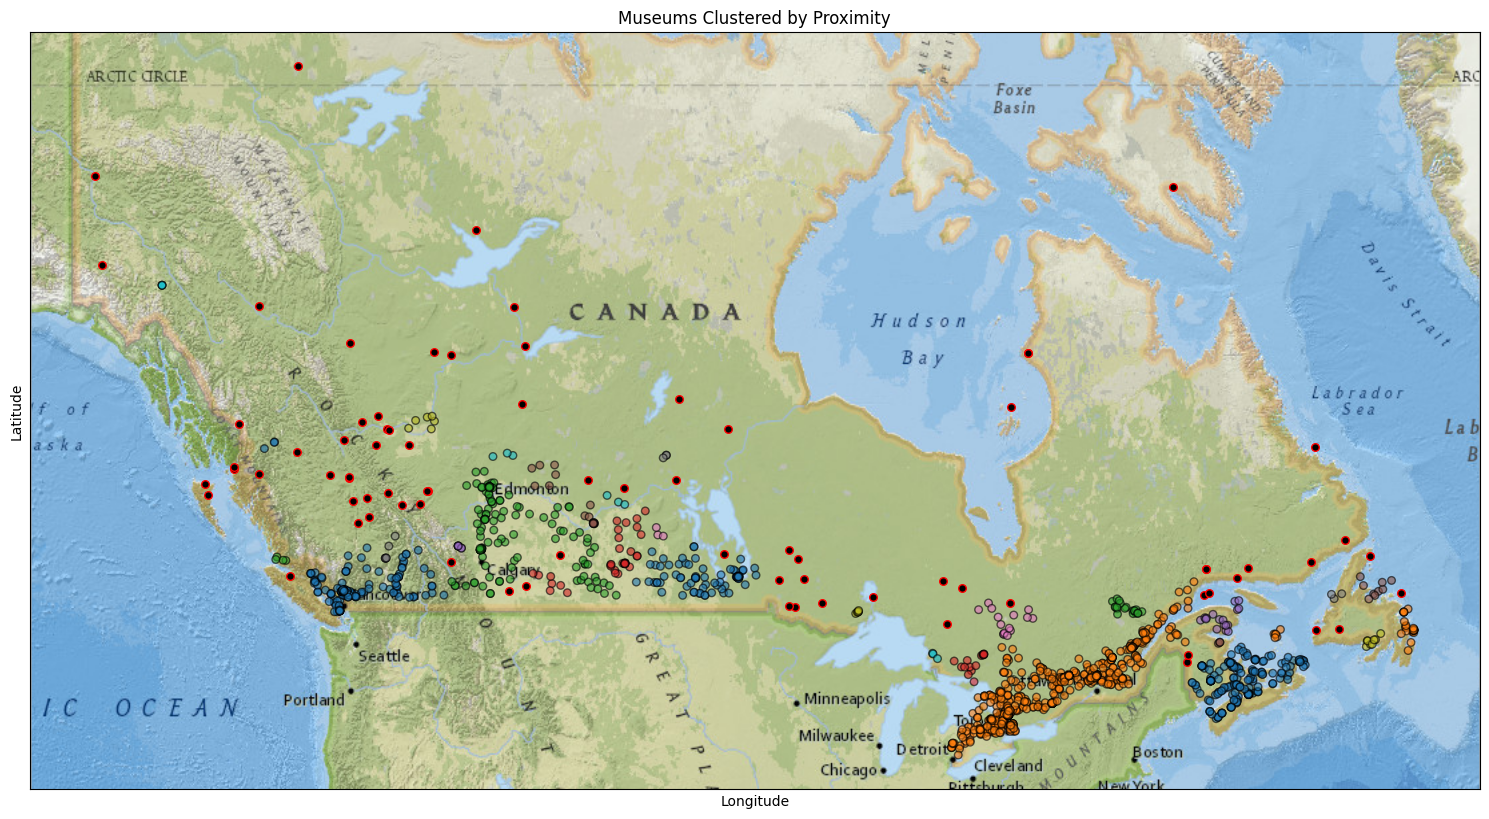

In [23]:
plot_clustered_locations(df, title='Museums Clustered by Proximity')

Here, the clusters are not uniformly dense. For example, the points are quite densely packed in a few regions but are relatively sparse in between. DBSCAN agglomerates neighboring clusters together when they are close enough.

Let's see how a hierarchical density-based clustering algorithm such as like `HDBSCAN` performs.

## Build an HDBSCAN clustering model


#### Initialize an HDBSCAN model


In [24]:
min_samples=None
min_cluster_size=3
hdb = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size, metric='euclidean') 

### Assign the cluster labels to your unscaled coordinate dataframe and display the counts of each cluster label.

In [25]:
# Assign labels
df['Cluster'] = hdb.fit_predict(coords_scaled)  # Another way to assign the labels

# Display the size of each cluster
df['Cluster'].value_counts()

Cluster
-1      461
 142     44
 91      39
 62      36
 82      29
       ... 
 110      3
 133      3
 124      3
 0        3
 122      3
Name: count, Length: 144, dtype: int64

Unlike the case for DBSCAN, clusters quite uniformly sized, although there is a quite lot of noise identified.

### Plot the hierarchically clustered museums on a basemap of Canada, colored by cluster label.

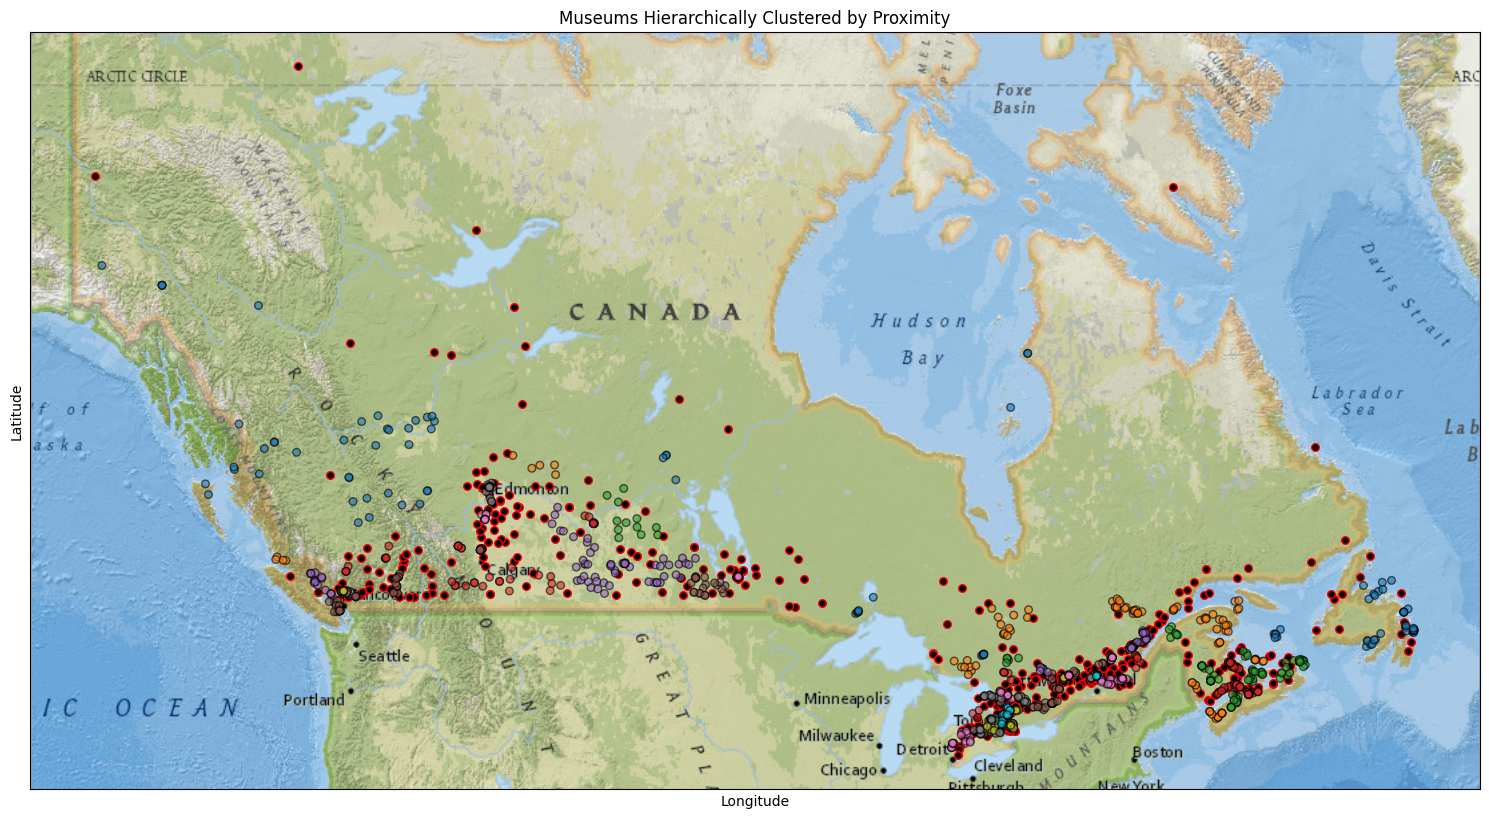

In [26]:
plot_clustered_locations(df, title='Museums Hierarchically Clustered by Proximity')


### Remarks

1. `HDBSCAN` produces more compact, uniformly sized clusters, whereas `DBSCAN`tends to group dense neighboring regions into a few large clusters. You might notice that `DBSCAN` merged several adjacent museums into superclusters, while `HDBSCAN` split them up more deliberately.

2. Initially it may look like HDBSCAN marked more points as noise (label -1), but because it uses a more nuanced approach to density, it's actually filtering out points that DBSCAN might've forced into clusters—possibly incorrectly. 

3. HDBSCAN handles areas of varying point density. For instance, downtown Toronto or Vancouver might naturally have tighter, denser museum clusters, while rural areas are sparser. **HDBSCAN adapts**, whereas DBSCAN uses a fixed neighborhood radius, which isn’t always optimal across the full dataset.